In [1]:
import os
from pathlib import Path
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage.feature import local_binary_pattern
from sklearn import neighbors, linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy.stats import moment, kurtosis, skew
from sklearn.decomposition import PCA
import pywt
import cv2

In [2]:
# Feature Extraction - Local Binary Pattern
def lbp_feature_extraction(im, n_points, radius, method):
    hist_ini = []
    #im_gray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2GRAY)
    for i in range(3):
        lbp = local_binary_pattern(im[:,:,i], n_points, radius, method)
        # Features returned are the hisogram of resulting data from lbp algorithm
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, radius + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)    
        hist_ini.append(hist)
 
    hist_ini = np.array(hist_ini)
    return hist_ini.ravel()

In [3]:
# Feature Extraction - Denoise Wavelets
def den_wavelets(noise):    
    resp = []
    n_moments = 9
    for i in range(np.shape(noise)[2]):
        coeffs = pywt.dwt2(noise[:,:,i], 'haar')
        cA, (cH, cV, cD) = coeffs
        for j in range(1,n_moments+1):
            resp.append(moment(cH.ravel(), moment=j))
            resp.append(moment(cV.ravel(), moment=j))
            resp.append(moment(cD.ravel(), moment=j))
        resp.append(kurtosis(cH.ravel()))
        resp.append(kurtosis(cV.ravel()))
        resp.append(kurtosis(cD.ravel()))
        resp.append(skew(cH.ravel()))
        resp.append(skew(cV.ravel()))
        resp.append(skew(cD.ravel()))
    return resp

In [4]:
def crop_center_image(im, rows, columns):
    im = rgb_image
    h_mean = np.shape(im)[0]//2
    l_mean = np.shape(im)[1]//2
    rows_inc = rows//2
    columns_inc = columns//2
    im = im[h_mean-rows_inc:h_mean+rows_inc, l_mean-columns_inc:l_mean+columns_inc,:]
    return im

(2688, 1520, 3)
../Kaggle-camera-model-identification/data/train/HTC-1-M7/(HTC-1-M7)111.jpg
0.532596
(99,)


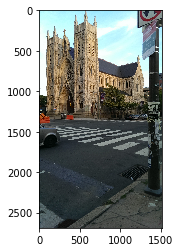

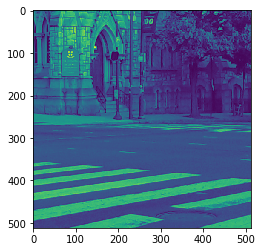

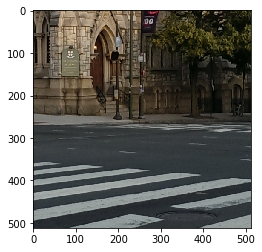

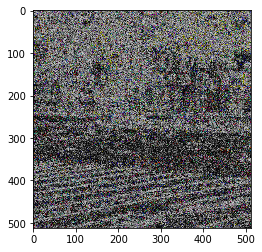

In [47]:
seg = train[train['camera'] == cameras[1]]
seg = seg.reset_index()
path_im = train_path / seg.at[0, 'camera'] / seg.at[14, 'fname']
bgr_image = cv2.imread(str(path_im))
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
#im = cv2.resize(rgb_image, (128, 128))
im = rgb_image

print(np.shape(im))

print(path_im)

plt.imshow(im)
c = plt.figure()
start = time.time()
crop = crop_center_image(im, 512, 512)
gray_image = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
c.savefig('aaa')
end = time.time()
print('%f'%(end-start))
plt.figure()
im_clean = denoise_wavelet(crop, multichannel=True)
noise = np.abs(crop - 255*im_clean)
plt.imshow(im_clean)
teste = plt.figure()
plt.imshow(noise)
teste.savefig('foo.png')

b = den_wavelets(crop)
print(np.shape(b))

In [5]:
is_kaggle = False
# Generating train and test path
if is_kaggle:
    input_path = Path('../input')
else:
    input_path = Path('../Kaggle-camera-model-identification/data')
train_path = input_path / 'train'
test_path = input_path / 'test'

In [6]:
# Listing all directories in trainning path
cameras = os.listdir(train_path)

In [7]:
# Defining size of trainning
size_train = 0.8

In [8]:
# Generating DataFrame of images and labes in the trainning and validation dataset
train_images = []
n_pictures = []

for camera in cameras:
    pic = len(os.listdir(train_path / camera))
    n_pictures.append(pic)
    for fname in sorted(os.listdir(train_path / camera)):
            train_images.append((camera, fname))
train = pd.DataFrame(train_images, columns=['camera', 'fname'])

In [9]:
# Generating DataFrame of images and labes in the testing dataset
test_images = []
for fname in sorted(os.listdir(test_path)):
    test_images.append(fname)
test = pd.DataFrame(test_images, columns=['fname'])

In [10]:
# Procedure to mount feature vectors of trainning and validation
train_lbp = []
train_wav = []
valid_lbp = []
valid_wav = []
train_target = []
valid_target = []

im_mean_vec = []
im_mean = 0

j = 0

start = time.time()
for camera in cameras:
    print("Feature extraction: %s"%(camera))
    for i in range(275):
        print("Example %i"%i, end = '\r')
        seg = train[train['camera'] == camera]
        seg = seg.reset_index()
        path_im = train_path / seg.at[i, 'camera'] / seg.at[i, 'fname']
        bgr_image = cv2.imread(str(path_im))
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        #im = rgb_image
        im = crop_center_image(rgb_image, 512, 512)
        im_clean = denoise_wavelet(im, multichannel=True)
        noise = np.abs(im - 255*im_clean)
        #im = cv2.resize(rgb_image, (512, 512))
        if i < 220:
            train_wav.append(den_wavelets(noise))
            train_lbp.append(lbp_feature_extraction(noise, 24, 8, 'uniform'))
            train_target.append(seg.at[i, 'camera'])
        else:
            valid_wav.append(den_wavelets(noise))
            valid_lbp.append(lbp_feature_extraction(noise, 24, 8, 'uniform'))
            valid_target.append(seg.at[i, 'camera']) 
    j += 1
    print("Extraction finished!\n")
end = time.time()

print('The time elapsed to extract all features was: %.2f min'%((end-start)/60))

Feature extraction: Motorola-Nexus-6
Extraction finished!

Feature extraction: HTC-1-M7
Extraction finished!

Feature extraction: LG-Nexus-5x
Extraction finished!

Feature extraction: Motorola-Droid-Maxx
Extraction finished!

Feature extraction: Motorola-X
Extraction finished!

Feature extraction: Samsung-Galaxy-S4
Extraction finished!

Feature extraction: Samsung-Galaxy-Note3
Extraction finished!

Feature extraction: iPhone-6
Extraction finished!

Feature extraction: iPhone-4s
Extraction finished!

Feature extraction: Sony-NEX-7
Extraction finished!

The time elapsed to extract all features was: 34.92 min


In [11]:
test_feat = []

test_feat_vec = []
test_lbp_vec = []
test_wav_vec = []
test_corr_vec = []

print('fname,camera')
for i in range(np.shape(test)[0]):
    print('%i'%i, end ='\r')
    path_im = test_path /  test.at[i, 'fname']
    bgr_image = cv2.imread(str(path_im))
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    im = rgb_image
    im_clean = denoise_wavelet(im, multichannel=True)
    noise = np.abs(im - 255*im_clean)
    test_wav = den_wavelets(noise)
    
    test_wav = np.array(test_wav).reshape(1,-1)
    test_lbp = lbp_feature_extraction(noise, 24, 8, 'uniform')
    test_feat = np.concatenate((test_wav[0], test_lbp), axis=0)

    test_feat_vec.append(test_feat)
    test_wav_vec.append(test_wav[0])
    test_lbp_vec.append(test_lbp)

fname,camera


In [12]:
train_wav = np.array(train_wav)
train_wav = train_wav.reshape(np.shape(train_wav)[0],-1)

valid_wav = np.array(valid_wav)
valid_wav = valid_wav.reshape(np.shape(valid_wav)[0],-1)

final_feat = np.concatenate((train_wav, train_lbp), axis=1)
final_valid = np.concatenate((valid_wav, valid_lbp), axis=1)

In [16]:
scaler_final = StandardScaler()
final_feat_m = scaler_final.fit_transform(final_feat)
final_valid_m = scaler_final.transform(final_valid)
test_feat_vec_m = scaler_final.transform(test_feat_vec)

scaler = StandardScaler()
train_wav_m = scaler.fit_transform(train_wav)
valid_wav_m = scaler.transform(valid_wav)
test_wav_vec_m = scaler.transform(test_wav_vec)

scaler_lbp = StandardScaler()
train_lbp_m = scaler_lbp.fit_transform(train_lbp)
valid_lbp_m = scaler_lbp.transform(valid_lbp)
test_lbp_vec_m = scaler_lbp.transform(test_lbp_vec)

In [17]:
#Predicting using logistic regression
logistic = linear_model.LogisticRegression()
print('Logistic Regression\nTrainning')
print('LBP - Score: %.2f'%(logistic.fit(train_lbp_m, train_target).score(train_lbp_m, train_target)))
print('WAV - Score: %.2f'%(logistic.fit(train_wav_m, train_target).score(train_wav_m, train_target)))
print('ALL - Score: %.2f'%(logistic.fit(final_feat_m, train_target).score(final_feat_m, train_target)))
print('Validation')
print('LBP - Score: %.2f'%(logistic.fit(train_lbp_m, train_target).score(valid_lbp_m, valid_target)))
print('WAV - Score: %.2f'%(logistic.fit(train_wav_m, train_target).score(valid_wav_m, valid_target)))
print('ALL - Score: %.2f\n'%(logistic.fit(final_feat_m, train_target).score(final_valid_m, valid_target)))

# Predicting using KNN
knn = neighbors.KNeighborsClassifier()
print('K-Nearest Neighbors\nTrainning')
print('LBP - Score: %.2f'%(knn.fit(train_lbp_m, train_target).score(train_lbp_m, train_target)))
print('WAV - Score: %.2f'%(knn.fit(train_wav_m, train_target).score(train_wav_m, train_target)))
print('ALL - Score: %.2f'%(knn.fit(final_feat_m, train_target).score(final_feat_m, train_target)))
print('Validation')
print('LBP - Score: %.2f'%(knn.fit(train_lbp_m, train_target).score(valid_lbp_m, valid_target)))
print('WAV - Score: %.2f'%(knn.fit(train_wav_m, train_target).score(valid_wav_m, valid_target)))
print('ALL - Score: %.2f\n'%(knn.fit(final_feat_m, train_target).score(final_valid_m, valid_target)))

# Predicting using logistic regression
mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(200), random_state=1, max_iter = 300)
print('Multilayer Perceptron\nTrainning')
print('LBP - Score: %.2f'%(mlp.fit(train_lbp_m, train_target).score(train_lbp_m, train_target)))
print('WAV - Score: %.2f'%(mlp.fit(train_wav_m, train_target).score(train_wav_m, train_target)))
print('ALL - Score: %.2f'%(mlp.fit(final_feat_m, train_target).score(final_feat_m, train_target)))
print('Validation')
print('LBP - Score: %.2f'%(mlp.fit(train_lbp_m, train_target).score(valid_lbp_m, valid_target)))
print('WAV - Score: %.2f'%(mlp.fit(train_wav_m, train_target).score(valid_wav_m, valid_target)))
print('ALL - Score: %.2f'%(mlp.fit(final_feat_m, train_target).score(final_valid_m, valid_target)))

Logistic Regression
Trainning
LBP - Score: 0.43
WAV - Score: 0.44
ALL - Score: 0.61
Validation
LBP - Score: 0.35
WAV - Score: 0.41
ALL - Score: 0.54

K-Nearest Neighbors
Trainning
LBP - Score: 0.56
WAV - Score: 0.62
ALL - Score: 0.68
Validation
LBP - Score: 0.32
WAV - Score: 0.42
ALL - Score: 0.53

Multilayer Perceptron
Trainning
LBP - Score: 0.67
WAV - Score: 0.56
ALL - Score: 0.86
Validation
LBP - Score: 0.46
WAV - Score: 0.47
ALL - Score: 0.64


In [32]:
submit = []

mlp.fit(final_feat_m, train_target)

pred = mlp.predict(test_feat_vec_m)
    
for i in range(np.shape(test)[0]):
    print(pred[i])
    submit.append([test.at[i, 'fname'], pred[i]])

Motorola-X
Motorola-Nexus-6
iPhone-6
iPhone-6
Motorola-X
Motorola-Droid-Maxx
Motorola-Droid-Maxx
Motorola-X
Motorola-X
Motorola-X
Motorola-X
HTC-1-M7
Motorola-Nexus-6
Samsung-Galaxy-Note3
Motorola-X
Sony-NEX-7
Motorola-Nexus-6
HTC-1-M7
Samsung-Galaxy-S4
Motorola-Droid-Maxx
Motorola-X
Motorola-Nexus-6
HTC-1-M7
Motorola-Droid-Maxx
Samsung-Galaxy-S4
Sony-NEX-7
Motorola-X
iPhone-6
Motorola-Nexus-6
iPhone-6
Motorola-Droid-Maxx
Motorola-Nexus-6
iPhone-6
iPhone-4s
LG-Nexus-5x
Samsung-Galaxy-Note3
Samsung-Galaxy-Note3
Motorola-X
Motorola-X
iPhone-6
Motorola-X
Sony-NEX-7
Motorola-Droid-Maxx
HTC-1-M7
Motorola-Nexus-6
Motorola-Nexus-6
Samsung-Galaxy-Note3
HTC-1-M7
HTC-1-M7
Motorola-Nexus-6
Samsung-Galaxy-Note3
Motorola-Droid-Maxx
Motorola-Nexus-6
iPhone-6
Sony-NEX-7
Samsung-Galaxy-Note3
Motorola-X
Samsung-Galaxy-S4
iPhone-6
iPhone-6
HTC-1-M7
Motorola-X
iPhone-6
Motorola-Droid-Maxx
Motorola-Droid-Maxx
LG-Nexus-5x
Samsung-Galaxy-Note3
Motorola-X
LG-Nexus-5x
Motorola-Droid-Maxx
Motorola-Droid-Maxx
L

HTC-1-M7
Sony-NEX-7
Motorola-X
Samsung-Galaxy-S4
HTC-1-M7
Motorola-Nexus-6
Motorola-Nexus-6
Motorola-Nexus-6
HTC-1-M7
Sony-NEX-7
Motorola-Nexus-6
LG-Nexus-5x
Sony-NEX-7
Motorola-Droid-Maxx
HTC-1-M7
HTC-1-M7
iPhone-4s
Motorola-Nexus-6
Motorola-X
Motorola-X
Sony-NEX-7
HTC-1-M7
Motorola-X
iPhone-6
HTC-1-M7
HTC-1-M7
LG-Nexus-5x
LG-Nexus-5x
iPhone-6
Motorola-Droid-Maxx
Motorola-Droid-Maxx
Motorola-X
LG-Nexus-5x
Sony-NEX-7
iPhone-6
iPhone-6
Motorola-X
iPhone-6
iPhone-6
iPhone-6
Motorola-X
Sony-NEX-7
Sony-NEX-7
Motorola-Droid-Maxx
LG-Nexus-5x
iPhone-6
Motorola-Nexus-6
Motorola-Droid-Maxx
iPhone-6
Motorola-Nexus-6
HTC-1-M7
Sony-NEX-7
Motorola-X
Motorola-Nexus-6
Motorola-X
LG-Nexus-5x
LG-Nexus-5x
Samsung-Galaxy-S4
Motorola-X
Samsung-Galaxy-S4
Motorola-X
iPhone-4s
Motorola-Nexus-6
Motorola-Nexus-6
Motorola-Nexus-6
Sony-NEX-7
HTC-1-M7
Motorola-X
Samsung-Galaxy-Note3
Motorola-Nexus-6
Motorola-X
Sony-NEX-7
HTC-1-M7
HTC-1-M7
Samsung-Galaxy-S4
Motorola-X
Motorola-X
Samsung-Galaxy-S4
Motorola-X
iPhone

In [33]:
submit_pd = pd.DataFrame(submit, columns=['fname', 'camera'])

print(submit_pd)

submit_pd.to_csv('submission_final_MLP_LBP_3channels', index = False)

                      fname                camera
0     img_0002a04_manip.tif            Motorola-X
1     img_001e31c_unalt.tif      Motorola-Nexus-6
2     img_00275cf_manip.tif              iPhone-6
3     img_0034113_unalt.tif              iPhone-6
4     img_00344b7_unalt.tif            Motorola-X
5     img_0062ce8_manip.tif   Motorola-Droid-Maxx
6     img_00885c3_manip.tif   Motorola-Droid-Maxx
7     img_008a869_unalt.tif            Motorola-X
8     img_008fb06_manip.tif            Motorola-X
9     img_00c98af_manip.tif            Motorola-X
10    img_00d0e3b_unalt.tif            Motorola-X
11    img_00e097a_manip.tif              HTC-1-M7
12    img_00f61b7_unalt.tif      Motorola-Nexus-6
13    img_010d9d4_unalt.tif  Samsung-Galaxy-Note3
14    img_011d3a0_manip.tif            Motorola-X
15    img_015b5e1_unalt.tif            Sony-NEX-7
16    img_015b7e6_manip.tif      Motorola-Nexus-6
17    img_017184c_unalt.tif              HTC-1-M7
18    img_0184cda_unalt.tif     Samsung-Galaxy-S4
